<div class="alert alert-info">
    <h1>Cervino: Build TOML file</h1>
</div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

<div class="alert alert-info">
    <h2>Import packages</h2>
</div>

In [2]:
from pprint import pprint

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle

In [4]:
# Imports for Cervino.
from cervino import *

<div class="alert alert-info">
    <h2>Define source locations - 2D line</h2>
</div>

In [5]:
locations = [(x, 0.0, 20.0) for x in range(2000, 6001, 1500)]
pprint(locations)

[(2000, 0.0, 20.0), (3500, 0.0, 20.0), (5000, 0.0, 20.0)]


<div class="alert alert-info">
    <h2>Build generic TOML dictionary for forward simulation</h2>
</div>

We now build the TOML dictionary which will define the simulation. To do so, we build each section of the TOML dictionary in separate notebook cells.

<div class="alert alert-info">
    <h3>General setup</h3>
</div>

In this initial section, we define a few general parameters required by the simulation.

In [6]:
def toml_general_dict(uid: str):
    return get_general_dict(uid=uid,
                            task_type='compute_forward_simulation',
                            solver='matterhorn',
                            desc='Matterhorn and marmousi')

In [7]:
# general_dict

<div class="alert alert-info">
    <h3>Domain setup</h3>
</div>

In this section, we need to define the model used for the simulation. In the example below, we choose the original Marmousi model. First thing, we need to obtain the binary files from the internet.

In [8]:
dataset, fn_h5 = utils.models.marmousi_original(solver='matterhorn', overwrite=True, verbose=True)
print(fn_h5)

This function will fetch the Marmousi model and prepare it for the chosen solver.To do so, it will create the directory 'marmousi_original_model' in the current working directory '/work/bfilippo/cervino/notebooks'.
The existing directory '/work/bfilippo/cervino/notebooks/marmousi_original_model' has been removed.
The archive 'marmousi_archive.tar.gz' already exists.
/work/bfilippo/cervino/notebooks/marmousi_original_model/marmousi_original.h5


We then set the velocity and density models directly from the HDF5 created by the utility above:

In [9]:
# We instantiate an AcousticDomain object:
domain = AcousticDomain()

# Set the models
# domain.set_model_from_hdf5(fn_h5)
domain.set_model_from_xarray(dataset, fn_h5=fn_h5)

def toml_domain_dict():
    return domain.get_domain_dict()

'y' coordinate is not present in the xarray Dataset: 2D domain


Alternatively, we can set the models from NumPy ndarrays. To do so, we need to create a dictionary with the necessary parameters:

In [10]:
# def toml_domain_dict(uid=None):
    
#     # We instantiate an AcousticDomain object:
#     domain = AcousticDomain()

#     geometry_dict = {
#         'cell-size': (4.0, 4.0, 4.0),
#         'number-of-cells': (2301, 1, 751),
#         'origin': (0.0, 0.0, 0.0)
#     }

#     # We need to create an ndarray with the right shape:

#     num_required_models = len(domain.required_models) # Acoustic: 2
#     models_array = np.empty((num_required_models, geometry_dict['number-of-cells'][0], geometry_dict['number-of-cells'][2]), dtype=np.float32)
#     print(f"The shape of the array is {models_array.shape}")

#     print(f"The required models are {domain.required_models}")

#     # Here we are loading the models from binary files (created by the utility above)
#     # to eventually recreate these binary files!
#     # This is only done to show how to use the set_model_from_numpy method
#     # The order of the models is important - See above
#     models_array[0, ...] = np.fromfile('marmousi_original_model/marmousi_original_vp.bin', dtype=np.float32).reshape((models_array[0, ...].shape))
#     models_array[1, ...] = np.fromfile('marmousi_original_model/marmousi_original_rho.bin', dtype=np.float32).reshape((models_array[0, ...].shape))

#     plt.imshow(models_array[1, ...].T)

#     fn_numpy_prefix = 'marmousi_numpy_original/marmousi_original'

#     # We finally set the velocity and density models from the ndarray:

#     domain.set_model_from_numpy(models_array, geometry=geometry_dict, fn_prefix=fn_numpy_prefix, solver='matterhorn', create_hdf5=True)

#     return domain

<div class="alert alert-info">
    <h3>Time and frequency setup</h3>
</div>

Here we need to define the time step in seconds `time_step_in_seconds` and the number of time steps `number_of_timesteps`. In the example below, we first define the time step, initial, and final time, and use these values to compute the number of time steps. However, one could also define the number of time steps directly.

In [11]:
time_step_in_seconds = 4e-4
start_time_in_seconds = 0.0
# time_shift_in_seconds = 1.0
end_time_in_seconds = 2.0

# Time axis
t = np.arange(start_time_in_seconds, end_time_in_seconds, time_step_in_seconds)

number_of_timesteps = t.size

def toml_time_dict():
    return get_time_dict(ts=time_step_in_seconds, nt=number_of_timesteps)

<div class="alert alert-info">
    <h3>Source setup</h3>
</div>

Here, we define the input (sources) which will generate the wavefields. We can define a single point source or an array (boundary) of point sources. In the example below, we define a point source characterised by a Ricker wavelet as source time function.

In [12]:
# Use a Ricker wavelet as source time function
center_frequency = 30.0
stf = wavelets.RickerWavelet(t, fc=center_frequency, delay=1.5, delay_type='c', create_binary=True, fn_prefix='source')

#Additionally, we can also load a user-defined wavelet from a binary file.

filename = 'user_defined_ricker_20hz.bin'
stf = UserWavelet(filename, nt=t.size)

# Define a point source
name = "source0"
#location = locations[0] #(4000.0, 0.0, 20.0)
spatial_type = "fz"
scale = 1.

def toml_source_dict(uid: str=None, location: list=None):
    return PointSource(loc=location, stf=stf, spatial_type=spatial_type).get_source_dict()

In [13]:
# Plot the source time function
# This will be implemented in the PointSource class
# plt.plot(t, toml_input_dict().stf.wavelet)
# _ = plt.title('Ricker wavelet')
# _ = plt.xlabel('Time [s]')

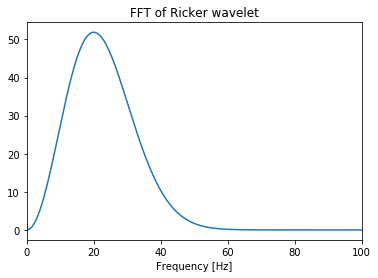

In [14]:
# We compute the FFT of the source time function. The values of the FFT at specific frequencies will be required later when defining DFT slice outputs.

# Frequency step in Hz
df = 1 / (time_step_in_seconds * number_of_timesteps)
Nfft = stf.wavelet.size

# Frequency axis
f = np.arange(Nfft) * df

# FFT
W = np.fft.fft(stf.wavelet)

# Plot
plt.plot(f, np.abs(W))
_ = plt.title('FFT of Ricker wavelet')
_ = plt.xlabel('Frequency [Hz]')
_ = plt.xlim([0, 100])

<div class="alert alert-info">
    <h3>Output setup</h3>
</div>

Here, we definte the output of the simulation. Now we create two shot gathers:

In [15]:
def toml_gather_dict(uid=None):
    # First we create a general gather object
    start_timestep = 0
    end_timestep = len(t) - 1
    timestep_increment = 10

    gather = Gather(start_timestep=start_timestep, end_timestep=end_timestep, timestep_increment=timestep_increment, fmt='su')

    n = domain.get_domain_dict()['geometry']['number-of-cells']
    d = domain.get_domain_dict()['geometry']['cell-size']

    # Number of receivers
    nr = n[0]
    # Receiver z-value
    rz0 = 40.0
    # x-value of first receiver
    rx0 = 0.0
    # x-value of last receiver
    rx1 = nr * d[0]

    # Then we define multiple receiver arrays
    rec0 = gather.add_receivers(uid, origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V01Z', filename="vz_gather")
    # rec1 = gather.add_receivers(uid, origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V10X', filename="vx_gather")
    
    return gather.get_receivers_dict()

In [16]:
a = toml_gather_dict('000')
# for i, j in a.items():
#     print(i)
#     print(j)
#     print(type(j))
for k, v in a['receivers'].items():
    for j in v.values():
        print(j)
        print(type(j))

(0.0, 0.0, 40.0)
<class 'tuple'>
(4.0, 0.0, 0.0)
<class 'tuple'>
2301
<class 'int'>
V01Z
<class 'str'>
000_0000_vz_gather
<class 'str'>


Additionally, we create time snapshots:

In [17]:
def toml_slice_dict(uid=None):
    # First we create a general snapshot object
    start_timestep = 0
    end_timestep = len(t) - 1
    timestep_increment = 100

    snapshot = TimeSlice(start_timestep=start_timestep, end_timestep=end_timestep, timestep_increment=timestep_increment, fmt='su')

    # Axis
    slice_axis = 'y'
    # Slice index
    slice_index = 0

    # Then we define two slices
    slice0 = snapshot.add_slices(uid, axis=slice_axis, slice_index=slice_index, attribute='V10X', filename="vx_slice")
    slice1 = snapshot.add_slices(uid, axis=slice_axis, slice_index=slice_index, attribute='V01Z', filename="vz_slice")
    
    return snapshot.get_slices_dict()

Additionally, we create DFT slices:

In [18]:
def toml_dft_dict(uid=None):
    # First we create a general snapshot object
    dft_frequencies = list(range(5, 81, 5))

    # Write wavelet coefficients to file
    dft_wavelet_coefficients = np.array([W[int(i / df)] for i in dft_frequencies], dtype=np.complex64)
    dft_wavelet_coefficients_fn = f"dft_wavelet_coefficients_source0.bin"
    dft_wavelet_coefficients.tofile(dft_wavelet_coefficients_fn)
    # np.array(dft_frequencies, np.float32).tofile(dft_wavelet_coefficients_fn)

    dft = DFTSlice(dft_frequencies=dft_frequencies, dft_wavelet_coefficients=dft_wavelet_coefficients_fn, fmt='su')

    # We define a DFT slice:

    # Axis
    slice_axis = 'y'
    # Slice index
    slice_index = 0

    dft_slice0 = dft.add_slices(uid, axis=slice_axis, slice_index=slice_index, attribute='S00XX', filename="sxx_dft_slice")
    
    return dft.get_slices_dict()

<div class="alert alert-info">
    <h3>Physics setup</h3>
</div>

In [19]:
# We define the PML boundary conditions:
pml_dict = get_pml_dict(fs=True, width=10, power=4, frequency=center_frequency, vel=3000.)

# We define the order of the spatial stencil:
def toml_physics_dict():
    return get_physics_dict(order=4, boundaries=[pml_dict,])

<div class="alert alert-info">
    <h3>Assemble complete TOML dictionary</h3>
</div>

In [20]:
# Generate the complete input dictionary.
def compute_forward_simulation_get_dict(uid, source_location):
    return {
        "general": toml_general_dict(uid),
        "domain": toml_domain_dict(),
        "time": toml_time_dict(),
        "physics": toml_physics_dict(),
        "source": {
            "point-source": toml_source_dict(uid, source_location),
        },
        "output": {
            "gather": toml_gather_dict(uid),
            "slice_time": toml_slice_dict(uid),
            "slice_dft": toml_dft_dict(uid),
        }
    }

In [21]:
f"{0:04d}"

'0000'

In [22]:
import diceware
diceware.main(['-n', '2', '-d', '_', '--no-caps']) #get_passphrase()

veal_overbuilt


In [23]:
tasks = {f"{i:04d}": compute_forward_simulation_get_dict(f"{i:04d}", loc) for i, loc in enumerate(locations)}

In [24]:
for uid, task in tasks.items():
    print(uid)
    pprint(task)

0000
{'domain': {'dimension': 2,
            'geometry': {'cell-size': [4.0, 1.0, 4.0],
                         'number-of-cells': [2301, 1, 751],
                         'origin': [0.0, 0.0, 0.0]},
            'model': {'filename': '/work/bfilippo/cervino/notebooks/marmousi_original_model/marmousi_original.h5',
                      'format': 'hdf5',
                      'required-models': ('VP', 'RHO')}},
 'general': {'desc': 'Matterhorn and marmousi',
             'site': None,
             'solver': 'matterhorn',
             'task_type': 'compute_forward_simulation',
             'uid': '0000',
             'user': None},
 'output': {'gather': {'end-timestep': 4999,
                       'format': 'su',
                       'receivers': {'gather_0000': {'attribute': 'V01Z',
                                                     'filename-prefix': '0000_0000_vz_gather',
                                                     'number-of-receivers': 2301,
                           

In [25]:
with open('tasks.pkl', 'wb') as f:
    pickle.dump(tasks, f)

In [29]:
with open('tasks.pkl', 'rb') as f:
    aa = pickle.load(f)